In [1]:
%reload_ext nb_black

<IPython.core.display.Javascript object>

## AB Testing

12_01_ab_testing_assign_solution

Introductory AB Testing walkthrough applied to the problem of determining if a change to a Website will lead to improved performance in a specific business metrics.

We also will introduce the math behind AB testing.

References:
- Wiki AB Testting  
https://en.wikipedia.org/wiki/A/B_testing

- The Essential Guide to Effect Sizes: Statistical Power, Meta-Analysis, and the Interpretation of Research Results, 2010. Page 60. 

- Stanford lecture on sample sizes  
http://statweb.stanford.edu/~susan/courses/s141/hopower.pdf

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

%matplotlib inline

<IPython.core.display.Javascript object>

### Topics

1. Set up the experiment
  * What is the goal? 
  * What is the metric? 
  * How much of an increase ("lift" in the metric) is worth the change? 
  * How much statistical power and level of significance do you need? Typically 80% and 0.05 are used respectively.
  
2. Set up a control group and test group by selecting users at random.

3. Run the test and record the success rate for each group.

4. Plot the distribution of the difference between the two samples.

5. Measure the probability of getting the result of the test group and the confidence interval. Check to see if there is enough statistical power and that the level of significance is achieved.

6. Consider other tradeoffs and decide if the change should be launched.

## Set up the experiment

The goal of running the AB test is to evaluate if a change in a website will lead to improved performance in a specific metric. 

You may decide to test very simple alternatives such as changing the look of a single button on a webpage or testing different layouts and headlines, or a multi-step processes which may have many differences. For examlple, signing up a new user.

## Variables

* Sample size
* Baseline conversion rate
* Minimum detectable effect
* Desired statistical power
* Confidence level or level of significance

## Control Group A and Test Group B
Typically, users are randomly selected and assigned to either a control group or a test group, and the total number of users participating in the A/B test make up a small percentage of the total amount of users. 

For this exercise, we will run an A/B test for a hypothetical company that is trying to get users to sign up for a premium account.

Initially, we will collect 1000 samples for each group and serve the current signup page to the control group and a new signup page to the test group.

### Run the Test

Since this is just a hypothetical case, we're going to generate synthetic data based on the binomial distribution. 

The binomial distribution with parameters n and p is the discrete probability distribution of the number of successes in a sequence of n independent experiments, each asking a yes–no question, and each with its own boolean-valued outcome: success / yes / true / one (with probability p) or failure / no / false / zero (with probability q = 1 − p). 

https://en.wikipedia.org/wiki/Binomial_distribution

In real-world applications, you will have to set up your experiment, and wait an amount of time needed to gather the data.

In [3]:
# A is control; B is test
n_a = 1000
n_b = 1000

<IPython.core.display.Javascript object>

You will also not be able to set the difference, `d_hat`, prior to your experiment, like we will be doing below for our hypothetical test.

In [4]:
# bcr: baseline conversion rate
# d_hat: difference in a metric between the two groups,
#   also referred to as minimal detectable effect or lift depending on the context
p_a = 0.10
p_b = 0.12

<IPython.core.display.Javascript object>

In [5]:
def generate_data(n_a, n_b, p_a, p_b):
    a_data = pd.DataFrame({"group": "A", "converted": np.random.binomial(1, p_a, n_a)})
    b_data = pd.DataFrame({"group": "B", "converted": np.random.binomial(1, p_b, n_b)})
    return pd.concat((a_data, b_data))

<IPython.core.display.Javascript object>

In [6]:
ab_data = generate_data(n_a, n_b, p_a, p_b)

<IPython.core.display.Javascript object>

First, we should perform some preliminary data analysis.

In [7]:
ab_data.head(5)

,group,converted
0,A,0
1,A,0
2,A,0
3,A,0
4,A,0


<IPython.core.display.Javascript object>

Verify the dimensionality of the data.

In [8]:
ab_data.shape

(2000, 2)

<IPython.core.display.Javascript object>

Next, determine how many users from each group converted.

Since we are using 1 for converted and 0 for not converted, we can `sum()` these values.

In [9]:
a_group = ab_data[ab_data["group"] == "A"]
b_group = ab_data[ab_data["group"] == "B"]

<IPython.core.display.Javascript object>

In [10]:
a_converted = a_group["converted"].sum()
a_converted

98

<IPython.core.display.Javascript object>

In [11]:
b_converted = b_group["converted"].sum()
b_converted

127

<IPython.core.display.Javascript object>

In [12]:
a_total = len(a_group)
a_total

1000

<IPython.core.display.Javascript object>

In [14]:
b_total = len(b_group)
b_total

1000

<IPython.core.display.Javascript object>

In [15]:
p_a = a_converted / a_total
p_a

0.098

<IPython.core.display.Javascript object>

In [16]:
p_b = b_converted / b_total
p_b

0.127

<IPython.core.display.Javascript object>

Calculate the difference in conversion rates, i.e., the "lift."

In [17]:
p_b - p_a

0.028999999999999998

<IPython.core.display.Javascript object>

Summarize our experimental results

In [18]:
ab_summary = ab_data.groupby("group").agg({"converted": ["sum", "size", "mean"]})
ab_summary.columns = ["converted", "total", "rate"]

<IPython.core.display.Javascript object>

In [19]:
ab_summary

,converted,total,rate
group,,,
A,98,1000,0.098
B,127,1000,0.127


<IPython.core.display.Javascript object>

The result should be similar to the parameters that we used to set up the test. 

In real world applications, we will not be able to *set* how much lift we would see in the test group a priori. 

When setting up an experiment, we need to decide how many samples are needed for the test, and we will probably know the baseline conversion rate for the control.

If you observe the conversion rate for both groups, you find that the new signup page resulted in an improvement of approximately 2%. This is good, but we need to demonstrate that this result is statistically significant.

## Compare the Two Samples


Plot the binomial distribution that corresponds to the control group `A` conversion rate.

Evaluate the probability of getting the result from the test group `B` based on the binomial distribution from the control group, plot the result.

In [20]:
result = p_b * a_total
result

127.0

<IPython.core.display.Javascript object>

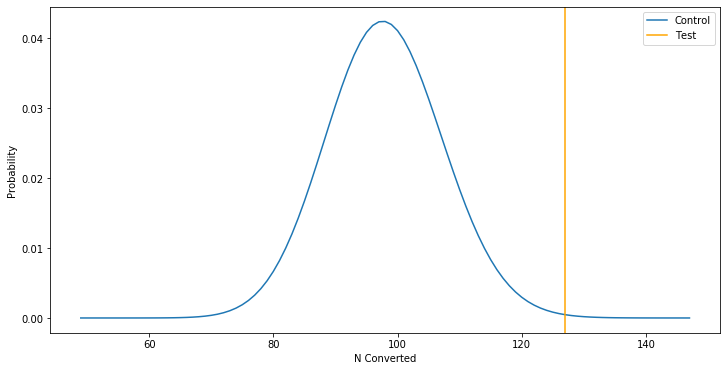

<IPython.core.display.Javascript object>

In [21]:
plt.figure(figsize=(12, 6))

x = range(a_converted - 49, a_converted + 50)
y = stats.binom(a_total, p_a).pmf(x)

plt.plot(x, y, label="Control")
plt.axvline(x=p_b * a_total, c="orange", label="Test")

plt.xlabel("N Converted")
plt.ylabel("Probability")
plt.legend()
plt.show()

Determine the p-value (probability of seeing the result assuming the null hypothesis) using `scipy.stats.pmf()` (probability mass function.)

In [22]:
stats.binom(a_total, p_a).pmf(int(result))

0.00046851383476279826

<IPython.core.display.Javascript object>

Is this enough evidence of statistical significance? 



### Assignment

**Question:**
    
Why didn't we use the t-test in the previous example?

In [ ]:
# It's a binomial distribution as a opposed to a continuous, normal distribution

**Programming:**
    
- Run `generate_data()` for 100 trials with the following parameters:  

    `N_A=1000, N_B=1000, p_A=0.10, p_B=0.12`

    `ab_data = generate_data(N_A, N_B, p_A, p_B)`

- For each trial, calculate and store the conversion rates for group A and group B.

- Run a t-Test on the conversion rate arrays for group A and group B.

In [23]:
a_conv_rates = []
b_conv_rates = []
for _ in range(100):

    ab_data = generate_data(n_a, n_b, p_a, p_b)
    # split them into groups
    a_group = ab_data[ab_data["group"] == "A"]
    b_group = ab_data[ab_data["group"] == "B"]

    a_converted = a_group["converted"].sum()
    b_converted = b_group["converted"].sum()

    a_total = len(a_group)
    b_total = len(b_group)

    p_a = a_converted / a_total
    p_b = b_converted / b_total
    # a_converted
    # lift = p_b - p_a
    a_conv_rates.append(p_a)
    b_conv_rates.append(p_b)

stats.ttest_ind(a_conv_rates, b_conv_rates)

Ttest_indResult(statistic=-22.750875964396364, pvalue=3.8011889615075774e-57)

<IPython.core.display.Javascript object>

Are the results statistically significant?

In [24]:
t, p = stats.ttest_ind(a_conv_rates, b_conv_rates)
print(p < 0.05)

True


<IPython.core.display.Javascript object>

Calculate a confidence interval to show the difference in conversion rates.

In [25]:
def get_95_ci(x1, x2):
    """Calculate a 95% CI for 2 1d numpy arrays"""
    signal = x1.mean() - x2.mean()
    noise = np.sqrt(x1.var() / x1.size + x2.var() / x2.size)

    ci_lo = signal - 1.96 * noise
    ci_hi = signal + 1.96 * noise

    return ci_lo, ci_hi


<IPython.core.display.Javascript object>

In [30]:
a_series = pd.Series((v for v in a_conv_rates))
b_series = pd.Series((v for v in b_conv_rates))

<IPython.core.display.Javascript object>

In [31]:
get_95_ci(a_series, b_series)

(-0.13569278559046233, -0.11416721440953775)

<IPython.core.display.Javascript object>